In [1]:
import devito
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []
g = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition
# Maximum wave propagation time [s]
Tmax = 1.
dt = 1/4500.
nt = (int)(Tmax/dt)
print(dt, nt)

0.00022222222222222223 4500


In [3]:
from devito import Grid, TimeFunction, Function

grid = Grid(shape=(ny, nx), extent=(Ly, Lx))
eta = TimeFunction(name='eta', grid=grid, space_order=2)
M = TimeFunction(name='M', grid=grid, space_order=2)
N = TimeFunction(name='N', grid=grid, space_order=2)
h = Function(name='h', grid=grid)
D = Function(name='D', grid=grid)

In [4]:
import numpy
# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h.data[:] = 50

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * numpy.exp(-((X-50)**2/10)-((Y-50)**2/10))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + 50.

In [5]:
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:] = D0.copy()

print(eta0.shape, h.data.shape)

(401, 401) (401, 401)


In [6]:
from devito import sqrt
frictionTerm = g * alpha**2 * sqrt(M**2 + N**2 ) / D**(7./3.)
frictionTerm

0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)

In [7]:
from devito import Eq, solve
pde_eta = Eq(eta.dt + M.dxc + N.dyc)
pde_M   = Eq(M.dt + (M**2/D).dxc + (M*N/D).dyc + g*D*eta.forward.dxc + frictionTerm*M)
pde_N   = Eq(N.dt + (M*N/D).dxc + (N**2/D).dyc + g*D*eta.forward.dyc + frictionTerm*N)

# Defining boundary conditions
x, y = grid.dimensions
t = grid.stepping_dim
bc_left   = Eq(eta[t+1, 0, y], eta[t+1, 1, y])
bc_right  = Eq(eta[t+1, nx-1, y], eta[t+1, nx-2, y])
bc_top    = Eq(eta[t+1, x, 0], eta[t+1, x, 1])
bc_bottom = Eq(eta[t+1, x, ny-1], eta[t+1, x, ny-2])

stencil_eta = solve(pde_eta, eta.forward)
stencil_M   = solve(pde_M, M.forward)
stencil_N   = solve(pde_N, N.forward)

update_eta  = Eq(eta.forward, stencil_eta, subdomain=grid.interior)
update_M    = Eq(M.forward, stencil_M, subdomain=grid.interior)
update_N    = Eq(N.forward, stencil_N, subdomain=grid.interior)
eq_D        = Eq(D, eta.forward + h)

update_eta

Eq(eta(t + dt, x, y), dt*(-Derivative(M(t, x, y), x) - Derivative(N(t, x, y), y) + eta(t, x, y)/dt))

In [8]:
update_M

Eq(M(t + dt, x, y), dt*(-0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)*M(t, x, y) - 9.81*D(x, y)*Derivative(eta(t + dt, x, y), x) - Derivative(M(t, x, y)**2/D(x, y), x) - Derivative(M(t, x, y)*N(t, x, y)/D(x, y), y) + M(t, x, y)/dt))

In [9]:
update_N

Eq(N(t + dt, x, y), dt*(-0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)*N(t, x, y) - 9.81*D(x, y)*Derivative(eta(t + dt, x, y), y) - Derivative(N(t, x, y)**2/D(x, y), y) - Derivative(M(t, x, y)*N(t, x, y)/D(x, y), x) + N(t, x, y)/dt))

In [10]:
from devito import Operator

optime = Operator([update_eta, bc_left, bc_right, bc_top, bc_bottom,
                   update_M, update_N, eq_D])

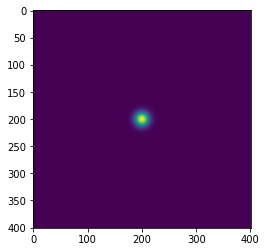

In [11]:
plt.imshow(eta.data[0])

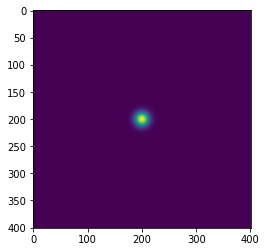

In [12]:
plt.imshow(M.data[0])

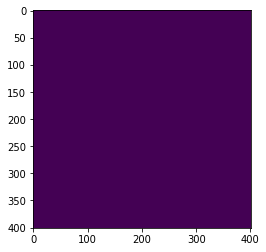

In [13]:
plt.imshow(N.data[0])

In [14]:
print(optime.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict D_vec, struct dataobj *restrict M_vec, struct dataobj *restrict N_vec, const float dt, struct dataobj *restrict eta_vec, struct dataobj *restrict h_vec, const float h_x, const float h_y, const int i0x_ltkn, const int i0x_rtkn, const int i0y_ltkn, const int i0y_rtkn, const int time_M, const int time_m, const int x_M, const int x_m, const in

Operator `Kernel` ran in 38.07 s


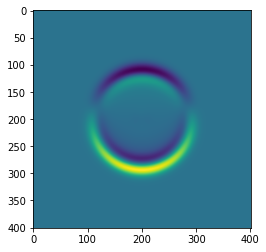

In [15]:
optime(time=nt, dt=dt)
plt.imshow(eta.data[1])

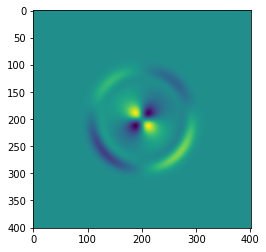

In [18]:
plt.imshow(N.data[1])

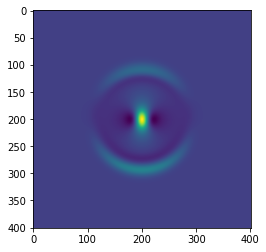

In [19]:
plt.imshow(M.data[1])